# Introduction  
  
In this kernel, I try blend models.  
This kernel is not high score but low overfitting.  
I try use two different dataset and make 4 models.  

In [1]:
from tqdm import tqdm
from collections import Counter
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import json
import pandas as pd
import numpy as np
import warnings
import random
import time
import os
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Lock, Process, Queue, current_process
import scipy as sp
from functools import partial
from numba import jit
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization
pd.set_option('display.max_columns', 1000)
warnings.filterwarnings('ignore')

In [2]:
def read_data():
    start = time.time()
    print("Start read data")

    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    #train = pd.read_csv('../input/data-science-bowl-2019/train.csv', nrows=1200000)
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    #test = pd.read_csv('../input/data-science-bowl-2019/test.csv', nrows=30000)

    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))

    print("read data done, time - ", time.time() - start)
    return train, test, train_labels, specs, sample_submission

In [3]:
def encode_title(train, test, train_labels):
    start = time.time()

    print("Start encoding data")
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))

    train['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), train['type'], train['world']))
    test['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), test['type'], test['world']))
    all_type_world = list(set(train["type_world"].unique()).union(test["type_world"].unique()))

    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(
        set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100 * np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    print("End encoding data, time - ", time.time() - start)


    event_data = {}
    event_data["train_labels"] = train_labels
    event_data["win_code"] = win_code
    event_data["list_of_user_activities"] = list_of_user_activities
    event_data["list_of_event_code"] = list_of_event_code
    event_data["activities_labels"] = activities_labels
    event_data["assess_titles"] = assess_titles
    event_data["list_of_event_id"] = list_of_event_id
    event_data["all_title_event_code"] = all_title_event_code
    event_data["activities_map"] = activities_map
    event_data["all_type_world"] = all_type_world

    return train, test, event_data

In [4]:
def get_all_features(feature_dict, ac_data):
    if len(ac_data['durations']) > 0:
        feature_dict['installation_duration_mean'] = np.mean(ac_data['durations'])
        feature_dict['installation_duration_sum'] = np.sum(ac_data['durations'])
    else:
        feature_dict['installation_duration_mean'] = 0
        feature_dict['installation_duration_sum'] = 0

    return feature_dict

In [5]:
def get_data(user_sample, event_data, test_set):
    '''
    The user_sample is a DataFrame from train or test where the only one
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_assesment = {}

    last_activity = 0

    user_activities_count = {'Clip': 0, 'Activity': 0, 'Assessment': 0, 'Game': 0}

    assess_4020_acc_dict = {'Cauldron Filler (Assessment)_4020_accuracy': 0,
                            'Mushroom Sorter (Assessment)_4020_accuracy': 0,
                            'Bird Measurer (Assessment)_4020_accuracy': 0,
                            'Chest Sorter (Assessment)_4020_accuracy': 0}

    game_time_dict = {'Clip_gametime': 0, 'Game_gametime': 0,
                      'Activity_gametime': 0, 'Assessment_gametime': 0}

    last_session_time_sec = 0
    accuracy_groups = {0: 0, 1: 0, 2: 0, 3: 0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0

    # Newly added features
    accumulated_game_miss = 0
    Cauldron_Filler_4025 = 0
    mean_game_round = 0
    mean_game_duration = 0
    mean_game_level = 0
    Assessment_mean_event_count = 0
    Game_mean_event_count = 0
    Activity_mean_event_count = 0
    chest_assessment_uncorrect_sum = 0

    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    durations_game = []
    durations_activity = []
    last_accuracy_title = {'acc_' + title: -1 for title in event_data["assess_titles"]}
    last_game_time_title = {'lgt_' + title: 0 for title in event_data["assess_titles"]}
    ac_game_time_title = {'agt_' + title: 0 for title in event_data["assess_titles"]}
    ac_true_attempts_title = {'ata_' + title: 0 for title in event_data["assess_titles"]}
    ac_false_attempts_title = {'afa_' + title: 0 for title in event_data["assess_titles"]}
    event_code_count: dict[str, int] = {ev: 0 for ev in event_data["list_of_event_code"]}
    event_code_proc_count = {str(ev) + "_proc" : 0. for ev in event_data["list_of_event_code"]}
    event_id_count: dict[str, int] = {eve: 0 for eve in event_data["list_of_event_id"]}
    title_count: dict[str, int] = {eve: 0 for eve in event_data["activities_labels"].values()}
    title_event_code_count: dict[str, int] = {t_eve: 0 for t_eve in event_data["all_title_event_code"]}
    type_world_count: dict[str, int] = {w_eve: 0 for w_eve in event_data["all_type_world"]}
    session_count = 0

    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = event_data["activities_labels"][session_title]

        if session_type == "Activity":
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1]) / 2.0

        if session_type == "Game":
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1]) / 2.0

            game_s = session[session.event_code == 2030]
            misses_cnt = cnt_miss(game_s)
            accumulated_game_miss += misses_cnt

            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round = (mean_game_round + game_round) / 2.0
            except:
                pass

            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) / 2.0
            except:
                pass

            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) / 2.0
            except:
                pass

        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session) > 1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {event_data["win_code"][session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens:
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(title_count.copy())
            features.update(game_time_dict.copy())
            features.update(event_id_count.copy())
            features.update(title_event_code_count.copy())
            features.update(assess_4020_acc_dict.copy())
            features.update(type_world_count.copy())
            features.update(last_game_time_title.copy())
            features.update(ac_game_time_title.copy())
            features.update(ac_true_attempts_title.copy())
            features.update(ac_false_attempts_title.copy())

            features.update(event_code_proc_count.copy())
            #features['installation_session_count'] = session_count
            features['accumulated_game_miss'] = accumulated_game_miss
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['chest_assessment_uncorrect_sum'] = chest_assessment_uncorrect_sum

            variety_features = [('var_event_code', event_code_count),
                                ('var_event_id', event_id_count),
                                ('var_title', title_count),
                                ('var_title_event_code', title_event_code_count),
                                ('var_type_world', type_world_count)]

            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)

            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts
            accumulated_uncorrect_attempts += false_attempts

            # ----------------------------------------------
            ac_true_attempts_title['ata_' + session_title_text] += true_attempts
            ac_false_attempts_title['afa_' + session_title_text] += false_attempts

            last_game_time_title['lgt_' + session_title_text] = session['game_time'].iloc[-1]
            ac_game_time_title['agt_' + session_title_text] += session['game_time'].iloc[-1]
            # ----------------------------------------------

            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
                features['last_duration'] = 0
                features['duration_max'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                features['last_duration'] = durations[-1]
                features['duration_max'] = np.max(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)

            if durations_game == []:
                features['duration_game_mean'] = 0
                features['duration_game_std'] = 0
                features['game_last_duration'] = 0
                features['game_max_duration'] = 0
            else:
                features['duration_game_mean'] = np.mean(durations_game)
                features['duration_game_std'] = np.std(durations_game)
                features['game_last_duration'] = durations_game[-1]
                features['game_max_duration'] = np.max(durations_game)

            if durations_activity == []:
                features['duration_activity_mean'] = 0
                features['duration_activity_std'] = 0
                features['game_activity_duration'] = 0
                features['game_activity_max'] = 0
            else:
                features['duration_activity_mean'] = np.mean(durations_activity)
                features['duration_activity_std'] = np.std(durations_activity)
                features['game_activity_duration'] = durations_activity[-1]
                features['game_activity_max'] = np.max(durations_activity)

            # the accuracy is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy / counter if counter > 0 else 0
            # --------------------------
            features['Cauldron_Filler_4025'] = Cauldron_Filler_4025 / counter if counter > 0 else 0

            Assess_4025 = session[(session.event_code == 4025) & (session.title == 'Cauldron Filler (Assessment)')]
            true_attempts_ = Assess_4025['event_data'].str.contains('true').sum()
            false_attempts_ = Assess_4025['event_data'].str.contains('false').sum()

            cau_assess_accuracy_ = true_attempts_ / (true_attempts_ + false_attempts_) if (
                                                                                                      true_attempts_ + false_attempts_) != 0 else 0
            Cauldron_Filler_4025 += cau_assess_accuracy_

            chest_assessment_uncorrect_sum += len(session[session.event_id == "df4fe8b6"])

            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1]) / 2.0
            # ----------------------------
            accuracy = true_attempts / (true_attempts + false_attempts) if (true_attempts + false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group / counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions

            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                last_assesment = features.copy()

            if true_attempts + false_attempts > 0:
                all_assessments.append(features)

            counter += 1

        if session_type == 'Game':
            durations_game.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)

        if session_type == 'Activity':
            durations_activity.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)

        session_count += 1

        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
            num_of_session_count = Counter(session[col])
            for k in num_of_session_count.keys():
                x = k
                if col == 'title':
                    x = event_data["activities_labels"][k]
                counter[x] += num_of_session_count[k]
            return counter

        def update_proc(count: dict):
            res = {}
            for k, val in count.items():
                res[str(k) + "_proc"] = (float(val) * 100.0) / accumulated_actions
            return res

        event_code_count = update_counters(event_code_count, "event_code")


        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        type_world_count = update_counters(type_world_count, 'type_world')

        assess_4020_acc_dict = get_4020_acc(session, assess_4020_acc_dict, event_data)
        game_time_dict[session_type + '_gametime'] = (game_time_dict[session_type + '_gametime'] + (
                    session['game_time'].iloc[-1] / 1000.0)) / 2.0

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        event_code_proc_count = update_proc(event_code_count)

        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type

            # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return last_assesment, all_assessments
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [6]:
def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

In [7]:
def get_4020_acc(df, counter_dict, event_data):
    for e in ['Cauldron Filler (Assessment)', 'Bird Measurer (Assessment)',
              'Mushroom Sorter (Assessment)', 'Chest Sorter (Assessment)']:
        Assess_4020 = df[(df.event_code == 4020) & (df.title == event_data["activities_map"][e])]
        true_attempts_ = Assess_4020['event_data'].str.contains('true').sum()
        false_attempts_ = Assess_4020['event_data'].str.contains('false').sum()

        measure_assess_accuracy_ = true_attempts_ / (true_attempts_ + false_attempts_) if (
                                                                                                      true_attempts_ + false_attempts_) != 0 else 0
        counter_dict[e + "_4020_accuracy"] += (counter_dict[e + "_4020_accuracy"] + measure_assess_accuracy_) / 2.0

    return counter_dict

In [8]:
def get_users_data(users_list, return_dict,  event_data, test_set):
    if test_set:
        for user in users_list:
            return_dict.append(get_data(user, event_data, test_set))
    else:
        answer = []
        for user in users_list:
            answer += get_data(user, event_data, test_set)
        return_dict += answer

In [9]:
def get_data_parrallel(users_list, event_data, test_set):
    manager = multiprocessing.Manager()
    return_dict = manager.list()
    threads_number = event_data["process_numbers"]
    data_len = len(users_list)
    processes = []
    cur_start = 0
    cur_stop = 0
    for index in range(threads_number):
        cur_stop += (data_len-1) // threads_number

        if index != (threads_number - 1):
            p = Process(target=get_users_data, args=(users_list[cur_start:cur_stop], return_dict, event_data, test_set))
        else:
            p = Process(target=get_users_data, args=(users_list[cur_start:], return_dict, event_data, test_set))

        processes.append(p)
        cur_start = cur_stop

    for proc in processes:
        proc.start()

    for proc in processes:
        proc.join()

    return list(return_dict)

In [10]:
def get_train_and_test(train, test, event_data):
    start = time.time()
    print("Start get_train_and_test")

    compiled_train = []
    compiled_test = []

    user_train_list = []
    user_test_list = []

    stride_size = event_data["strides"]
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=17000):
        user_train_list.append(user_sample)
        if (i + 1) % stride_size == 0:
            compiled_train += get_data_parrallel(user_train_list, event_data, False)
            del user_train_list
            user_train_list = []

    if len(user_train_list) > 0:
        compiled_train += get_data_parrallel(user_train_list, event_data, False)
        del user_train_list

    for i, (ins_id, user_sample) in tqdm(enumerate(test.groupby('installation_id', sort=False)), total=1000):
        user_test_list.append(user_sample)
        if (i + 1) % stride_size == 0:
            compiled_test += get_data_parrallel(user_test_list, event_data, True)
            del user_test_list
            user_test_list = []

    if len(user_test_list) > 0:
        compiled_test += get_data_parrallel(user_test_list, event_data, True)
        del user_test_list

    reduce_train = pd.DataFrame(compiled_train)

    reduce_test = [x[0] for x in compiled_test]

    reduce_train_from_test = []
    for i in [x[1] for x in compiled_test]:
        reduce_train_from_test += i

    reduce_test = pd.DataFrame(reduce_test)
    reduce_train_from_test = pd.DataFrame(reduce_train_from_test)
    categoricals = ['session_title']
    print("End get_train_and_test, time - ", time.time() - start)
    return reduce_train, reduce_test, reduce_train_from_test, categoricals

In [11]:
def get_train_and_test_single_proc(train, test, event_data):
    compiled_train = []
    compiled_test = []
    compiled_test_his = []
    for ins_id, user_sample in tqdm(train.groupby('installation_id', sort=False), total=17000):
        compiled_train += get_data(user_sample, event_data, False)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
        test_data = get_data(user_sample, event_data, True)
        compiled_test.append(test_data[0])
        compiled_test_his += test_data[1]


    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    reduce_test_his = pd.DataFrame(compiled_test_his)

    return reduce_train, reduce_test, reduce_test_his

In [12]:
# thank to Bruno
def eval_qwk_lgb_regr(y_pred, train_t):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(train_t['accuracy_group'])
    for k in dist:
        dist[k] /= len(train_t)

    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    #bound = [1.122, 1.739, 2.225]
    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred)))

    return y_pred

In [13]:
#def predict(sample_submission, y_pred):
#    sample_submission['accuracy_group'] = y_pred
#    sample_submission['accuracy_group'] = sample_submission['accuracy_group'].astype(int)
#    sample_submission.to_csv('submission.csv', index=False)
#    print(sample_submission['accuracy_group'].value_counts(normalize=True))

In [14]:
def get_random_assessment(reduce_train):
    used_idx = []
    for iid in tqdm(set(reduce_train['installation_id'])):
        list_ = list(reduce_train[reduce_train['installation_id']==iid].index)
        cur = random.choices(list_, k = 1)[0]
        used_idx.append(cur)
    reduce_train_t = reduce_train.loc[used_idx]
    return reduce_train_t, used_idx

In [15]:
# function to exclude columns from the train and test set if the mean is different, also adjust test column by a factor to simulate the same distribution
def exclude(reduce_train, reduce_test, features):
    to_exclude = []
    ajusted_test = reduce_test.copy()
    for feature in features:
        if feature not in ['accuracy_group', 'installation_id', 'session_title']:
            data = reduce_train[feature]
            train_mean = data.mean()
            data = ajusted_test[feature]
            test_mean = data.mean()
            try:
                ajust_factor = train_mean / test_mean
                if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                    to_exclude.append(feature)
                    print(feature)
                else:
                    ajusted_test[feature] *= ajust_factor
            except:
                to_exclude.append(feature)
                print(feature)
    return to_exclude, ajusted_test

In [16]:
def remove_correlated_features(reduce_train, features):
    counter = 0
    to_remove = []
    for feat_a in features:
        for feat_b in features:
            if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
                c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
                if c > 0.995:
                    counter += 1
                    to_remove.append(feat_b)
                    print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
    return to_remove

In [17]:
def main(reduce_train, reduce_test, reduce_train_from_test):
    
    random.seed(42)
    start_program = time.time()

    reduce_train.to_csv('reduce_train.csv', index=False, sep=";")
    reduce_test.to_csv('reduce_test.csv', index=False, sep=";")
    reduce_train_from_test.to_csv('reduce_train_from_test.csv', index=False, sep=";")


    reduce_train = pd.read_csv('reduce_train.csv', sep=";")
    reduce_test = pd.read_csv('reduce_test.csv', sep=";")
    reduce_train_from_test =  pd.read_csv('reduce_train_from_test.csv', sep=";")
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')


    reduce_train.sort_values("installation_id", axis=0, ascending=True, inplace=True, na_position='last')
    reduce_test.sort_values("installation_id", axis=0, ascending=True, inplace=True, na_position='last')

    reduce_train = pd.concat([reduce_train, reduce_train_from_test], ignore_index=True)

    old_features = list(reduce_train.columns[0:99]) + list(reduce_train.columns[886:])
    el_features = ['accuracy_group', 'accuracy', 'installation_id']
    old_features = [col for col in old_features if col not in el_features]
    event_id_features = list(reduce_train.columns[99:483])
    title_event_code_cross = list(reduce_train.columns[483:886])
    features = old_features + event_id_features + title_event_code_cross

    to_remove = remove_correlated_features(reduce_train, features)
    features = [col for col in features if col not in to_remove]

    features = [col for col in features if col not in ['Heavy, Heavier, Heaviest_2000', 'Heavy, Heavier, Heaviest']]
    features.append('installation_id')
    print('Training with {} features'.format(len(features)))

    to_exclude, ajusted_test = exclude(reduce_train, reduce_test, features)
    features = [col for col in features if col not in to_exclude]

    my_model = MyModel(reduce_train, features, kmodels=6, kfold=6)
    train_pred = my_model.predict(reduce_train)

    optR = OptimizedRounder()
    coefficients = [0.5, 1.5, 2.5]
    y = reduce_train['accuracy_group'].values
    print("Train cappa = ", qwk(y, train_pred))
    opt_preds = optR.predict(train_pred, coefficients)
    print("Train cappa = ", qwk(y, opt_preds))
    optR.fit(train_pred, y)
    coefficients = optR.coefficients()
    print("New coefs = ", coefficients)
    opt_preds = optR.predict(train_pred, coefficients)
    print("New train cappa rounding= ", qwk(y, opt_preds))
    train_rounding_origin = eval_qwk_lgb_regr(train_pred, reduce_train)
    print("Train cappa origin ", qwk(y, train_rounding_origin))

    y_final_0 = my_model.predict(ajusted_test)
    y_final = optR.predict(y_final_0, coefficients)
    #predict(sample_submission, y_final)
    print("Programm full time:", time.time() - start_program)
    
    return y_final, y_final_0

@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1,))
    hist2 = np.zeros((max_rat + 1,))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o += (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

In [18]:
class MyModel:
    def __init__(self, train, features, kmodels=5, kfold = 5):
        self.bin_models= []
        self.models = []
        self.features = features
        self.kfold = kfold


        params = {
            'num_boost_round': 1000,
            'boosting_type': 'gbdt', #'dart', 'dart', 'gbdt'
            #'metric':'regression',
            'objective': 'regression', #soft_kappa_obj, #'regression', #'regression',#regression',quantile fair huber poisson
            'n_jobs': -1,
            'seed': 42,
            'num_leaves': 32,
            'learning_rate': 0.08,
            'max_depth': 14,
            'lambda_l1': 2.0,
            'lambda_l2': 1.0,
            'bagging_fraction': 0.90,
            'bagging_freq': 1,
            'feature_fraction': 0.90,
            'early_stopping_rounds': 300,
            'verbose': 0,
        }

        oof_rmse_scores = []
        oof_cohen_scores = []

        for model_number in range(kmodels):
            kf = GroupKFold(n_splits=kfold)
            target = 'accuracy_group'
            oof_pred = np.zeros(len(train))
            ind = []

            for fold, (tr_ind, val_ind) in enumerate(kf.split(train, groups=train['installation_id'])):

                print('Fold:', fold + 1)
                x_train, x_val = train[features].iloc[tr_ind], train[features].iloc[val_ind]
                y_train, y_val = train[target][tr_ind], train[target][val_ind]
                x_train.drop('installation_id', inplace=True, axis=1)

                x_val, idx_val = get_random_assessment(x_val)
                ind.extend(idx_val)
                x_val.drop('installation_id', inplace=True, axis=1)
                y_val = y_val.loc[idx_val]

                train_set = lgb.Dataset(x_train, y_train, categorical_feature=['session_title'])
                val_set = lgb.Dataset(x_val, y_val, categorical_feature=['session_title'])

                model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=200,
                                  feval=eval_qwk_lgb_regr_metric,)
                                  #fobj=soft_kappa_obj,)
                                  #fobj=soft_kappa_obj,)
                ###

                self.models.append(model)
                reg_pred = model.predict(x_val)
                oof_pred[idx_val] = reg_pred

            oof_rmse_score = np.sqrt(mean_squared_error(train[target][ind], oof_pred[ind]))
            oof_cohen_score = cohen_kappa_score(train[target][ind],
                                            eval_qwk_lgb_regr(oof_pred[ind], train), weights='quadratic')

            print('Our oof rmse score is:', oof_rmse_score)
            print('Our oof cohen kappa score is:', oof_cohen_score)
            oof_rmse_scores.append(oof_rmse_score)
            oof_cohen_scores.append(oof_cohen_score)

        print('Our mean rmse score is: ', sum(oof_rmse_scores) / len(oof_rmse_scores))
        print('Our mean cohen kappa score is: ', sum(oof_cohen_scores) / len(oof_cohen_scores))



    def predict(self, test):
        current_features = [x for x in self.features if x not in ['installation_id']]
        y_pred = np.zeros(len(test))
        for model in self.models:
            y_pred += np.array(model.predict(test[current_features]), dtype=float)

        return y_pred / len(self.models)

In [19]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients

        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=[0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds

        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1.10, 1.72, 2.25]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead', options={
            'maxiter': 5000})

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds

        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [20]:
def soft_kappa_obj(y, p):
    y = np.asarray(y)
    p = np.asarray(p.label)
    norm = p.dot(p) + y.dot(y)

    grad = -2 * y / norm + 4 * p * np.dot(y, p) / (norm ** 2)
    hess = 8 * p * y / (norm ** 2) + 4 * np.dot(y, p) / (norm ** 2) - (16 * p ** 2 * np.dot(y, p)) / (norm ** 3)
    return grad, hess

In [21]:
def eval_qwk_lgb_regr_metric(y_pred, true):
    y_true=true.label

    dist = Counter(y_true)
    for k in dist:
        dist[k] /= len(y_true)

    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred)))

    return 'cappa', qwk(y_true, y_pred), True

# Prepare dataset

In [22]:
# read data
train, test, train_labels, specs, sample_submission = read_data()

Start read data
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns
read data done, time -  79.27022743225098


In [23]:
# get usefull dict with maping encode
train, test, event_data= encode_title(train, test, train_labels)

Start encoding data
End encoding data, time -  66.71298885345459


In [24]:
in_kaggle = True
if in_kaggle:
   event_data["strides"] = 300
   event_data["process_numbers"] = 4
else:
   event_data["strides"] = 300
   event_data["process_numbers"] = 3

In [25]:
# tranform function to get the train and test set
reduce_train, reduce_test, reduce_train_from_test, categoricals = get_train_and_test(train, test, event_data)

Start get_train_and_test


100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


End get_train_and_test, time -  2099.1990869045258


In [26]:
reduce_train.shape

(17690, 1003)

In [29]:
reduce_train.head(5)

,Clip,Activity,Assessment,Game,acc_Chest Sorter (Assessment),acc_Mushroom Sorter (Assessment),acc_Bird Measurer (Assessment),acc_Cauldron Filler (Assessment),acc_Cart Balancer (Assessment),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,12 Monkeys,Bug Measurer (Activity),Crystal Caves - Level 3,Fireworks (Activity),Ordering Spheres,Honey Cake,Chow Time,Scrub-A-Dub,Welcome to Lost Lagoon!,Magma Peak - Level 2,All Star Sorting,Dino Drink,Pirate's Tale,Slop Problem,Cauldron Filler (Assessment),Watering Hole (Activity),Magma Peak - Level 1,Tree Top City - Level 3,Sandcastle Builder (Activity),Dino Dive,Flower Waterer (Activity),Chest Sorter (Assessment),Mushroom Sorter (Assessment),Rulers,Bird Measurer (Assessment),Egg Dropper (Activity),Crystal Caves - Level 1,Costume Box,Crystals Rule,Leaf Leader,Treasure Map,Pan Balance,Happy Camel,Balancing Act,Tree Top City - Level 1,"Heavy, Heavier, Heaviest",Lifting Heavy Things,Tree Top City - Level 2,Cart Balancer (Assessment),Bottle Filler (Activity),Bubble Bath,Chicken Balancer (Activity),Crystal Caves - Level 2,Air Show,Clip_gametime,Game_gametime,Activity_gametime,Assessment_gametime,b80e5e84,ecaab346,1340b8d7,160654fd,8b757ab8,1375ccb7,c51d8688,c6971acf,51311d7a,92687c59,a2df0760,74e5f8a7,dcaede90,a592d54e,eb2c19cd,9ee1c98c,895865f3,bfc77bd6,ab4ec3a4,ca11f653,cfbd47c8,5dc079d8,b120f2ac,49ed92e9,8d748b58,89aace00,e57dd7af,17113b36,3bf1cf26,1f19558b,d2278a3b,250513af,3a4be871,5de79a6a,29a42aea,795e4a37,cdd22e43,3edf6747,392e14df,4c2ec19f,3d0b9317,84538528,923afab1,3babcb9b,532a2afb,565a3990,6f4bd64e,ec138c1c,a8876db3,30df3273,7dfe6d8a,f71c4741,884228c8,67439901,cb1178ad,2c4e6db0,df4fe8b6,1b54d27f,363d3849,4ef8cdd3,5290eab1,26fd2d99,9e4c8c7b,7cf1bc53,2b9272f4,c54cf6c5,8d84fa81,bc8f2793,6c930e6e,15eb4a7d,6f4adc4b,461eace6,d3268efa,832735e1,c189aaf2,7372e1a5,9b23e8ee,4e5fc6f5,a0faea5d,90efca10,7d5c30a2,56bcd38d,1575e76c,7525289a,d38c2fd7,022b4259,5a848010,262136f4,0413e89d,b2dba42b,e04fb33d,a52b92d5,5e812b27,6088b756,6043a2b4,b7530680,a76029ee,acf5c23f,45d01abe,63f13dd7,3323d7e9,7ad3efc6,9554a50b,83c6c409,7961e599,e080a381,14de4c5d,f5b8c21a,e4f1efe6,86ba578b,17ca3959,91561152,d51b1749,0a08139c,e37a2b78,28520915,b012cd7f,a5e9da97,5be391b5,3bb91dda,7da34a02,a7640a16,3bb91ced,792530f8,f6947f54,36fa3ebe,e64e2cfd,beb0a7b9,8af75982,bb3e370b,a8a78786,2a444e03,9d29771f,828e68f9,47f43a44,c1cac9a2,5d042115,26a5a3dd,47026d5f,d2e9262e,ea321fb1,69fdac0a,e79f3763,cf7638f3,9e34ea74,d185d3ea,29f54413,c952eb01,58a0de5c,003cd2ee,46b50ba8,88d4a5be,8ac7cce4,6c517a88,e694a35b,598f4598,77261ab5,070a5291,06372577,37c53127,9ce586dd,c2baf0bd,611485c5,37db1c2f,3afb49e6,3d8c61b0,0db6d71d,53c6e11a,30614231,93edfe2e,99abe2bb,d02b7a8e,38074c54,08fd73f3,e7e44842,25fa8af4,3afde5dd,a6d66e51,ecc36b7f,155f62a4,ac92046e,4074bac2,3ddc79c3,6f445b57,76babcde,8d7e386c,9e6b7fb5,2dcad279,499edb7c,6077cc36,ad148f58,5e109ec3,0330ab6a,9c5ef70c,4a09ace1,7fd1ac25,d06f75b5,b88f38da,f806dc10,4901243f,763fc34e,0ce40006,1af8be29,f3cd5473,f7e47413,c74f40cd,0d18d96c,1cc7cfca,00c73085,2b058fe3,55115cbd,907a054b,7f0836bf,77ead60d,5b49460a,d88e8f25,87d743c1,3393b68b,48349b14,4bb2f698,1c178d24,73757a5e,3dcdda7f,28a4eb9a,363c86c9,a29c5338,56817e2b,d45ed6a1,daac11b0,e720d930,d3f1e122,37ee8496,84b0e0c8,dcb55a27,9ed8f6da,9d4e7b25,f32856e4,e5c9df6f,a1e4395d,d9c005dd,cf82af56,27253bdc,ad2fc29c,02a42007,cb6010f8,a1192f43,28ed704e,93b353f2,f50fc6c1,c277e121,c0415e5c,709b1251,86c924c4,5e3ea25a,736f9581,e3ff61fb,5c2f29ca,71fe8f75,bd701df8,b74258a0,a8efe47b,8f094001,33505eae,c7fe2a55,d88ca108,56cd3b43,77c76bc5,15a43e5b,ab3136ba,28f975ea,15f99afc,2230fab4,562cec5f,31973d56,5154fc30,119b5b02,47efca07,9b01374f,4b5efe37,2ec694de,5859dfb6,19967db1,b5053438,85d1b0de,abc5811c,65a38bf7,222660ff,13f56524,b1d5101d,04df9b66,a5be6304,e4d32835,d2659ab4,f56e0afc,3d63345e,1996c610,e5734469,4a4c3d21,16667cc5,90e

# Build high score single model

In [30]:
if __name__ == '__main__':
    model1_y,model1_y_0 = main(reduce_train, reduce_test, reduce_train_from_test)

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 1.0
2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965872887962527
3: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965872887962527
4: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.9963724241535795
5: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.999983132917822
6: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
7: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9964587529783102
8: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998019600051506
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998019600051506
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.999983132917822
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.9963724241535795
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9964587529783102
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965872887962527
15: FEAT_A: 4230 FEAT_B: 4235 - Correlation: 0.9999995483783

100%|██████████| 694/694 [00:01<00:00, 580.66it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567282	training's cappa: 0.794586	valid_1's l2: 1.09511	valid_1's cappa: 0.535924
Early stopping, best iteration is:
[68]	training's l2: 0.774951	training's cappa: 0.688865	valid_1's l2: 1.07455	valid_1's cappa: 0.554417
Fold: 2


100%|██████████| 695/695 [00:01<00:00, 566.89it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.570553	training's cappa: 0.795275	valid_1's l2: 1.07573	valid_1's cappa: 0.548146
[400]	training's l2: 0.391313	training's cappa: 0.877644	valid_1's l2: 1.07573	valid_1's cappa: 0.547258
Early stopping, best iteration is:
[140]	training's l2: 0.647204	training's cappa: 0.755559	valid_1's l2: 1.0686	valid_1's cappa: 0.562349
Fold: 3


100%|██████████| 696/696 [00:01<00:00, 572.37it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567219	training's cappa: 0.79496	valid_1's l2: 1.12545	valid_1's cappa: 0.528072
Early stopping, best iteration is:
[51]	training's l2: 0.813014	training's cappa: 0.674527	valid_1's l2: 1.10481	valid_1's cappa: 0.514458
Fold: 4


100%|██████████| 696/696 [00:01<00:00, 585.20it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.562882	training's cappa: 0.798119	valid_1's l2: 1.05078	valid_1's cappa: 0.554282
[400]	training's l2: 0.385577	training's cappa: 0.880105	valid_1's l2: 1.05545	valid_1's cappa: 0.566229
Early stopping, best iteration is:
[212]	training's l2: 0.550253	training's cappa: 0.804096	valid_1's l2: 1.04492	valid_1's cappa: 0.557039
Fold: 5


100%|██████████| 695/695 [00:01<00:00, 579.95it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.572335	training's cappa: 0.792233	valid_1's l2: 1.01092	valid_1's cappa: 0.571034
Early stopping, best iteration is:
[67]	training's l2: 0.781133	training's cappa: 0.690059	valid_1's l2: 1.00354	valid_1's cappa: 0.59286
Fold: 6


100%|██████████| 695/695 [00:01<00:00, 581.36it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.564898	training's cappa: 0.796888	valid_1's l2: 1.03832	valid_1's cappa: 0.561359
[400]	training's l2: 0.388536	training's cappa: 0.877944	valid_1's l2: 1.05719	valid_1's cappa: 0.557779
Early stopping, best iteration is:
[100]	training's l2: 0.707992	training's cappa: 0.726225	valid_1's l2: 1.03283	valid_1's cappa: 0.582381
Our oof rmse score is: 1.0270727250980287
Our oof cohen kappa score is: 0.5616056423204684


 16%|█▌        | 112/694 [00:00<00:01, 555.03it/s]

Fold: 1


100%|██████████| 694/694 [00:01<00:00, 554.09it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567282	training's cappa: 0.794586	valid_1's l2: 1.12143	valid_1's cappa: 0.537277
Early stopping, best iteration is:
[66]	training's l2: 0.780008	training's cappa: 0.686594	valid_1's l2: 1.09358	valid_1's cappa: 0.551687
Fold: 2


100%|██████████| 695/695 [00:01<00:00, 586.69it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.570553	training's cappa: 0.795275	valid_1's l2: 1.06921	valid_1's cappa: 0.526201
Early stopping, best iteration is:
[3]	training's l2: 1.38912	training's cappa: 0.585957	valid_1's l2: 1.43154	valid_1's cappa: 0.541631
Fold: 3


100%|██████████| 696/696 [00:01<00:00, 570.93it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567219	training's cappa: 0.79496	valid_1's l2: 1.14163	valid_1's cappa: 0.513642
Early stopping, best iteration is:
[66]	training's l2: 0.775751	training's cappa: 0.691724	valid_1's l2: 1.13802	valid_1's cappa: 0.528512
Fold: 4


100%|██████████| 696/696 [00:01<00:00, 583.86it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.562882	training's cappa: 0.798119	valid_1's l2: 1.06317	valid_1's cappa: 0.533212
[400]	training's l2: 0.385577	training's cappa: 0.880105	valid_1's l2: 1.07949	valid_1's cappa: 0.534137
Early stopping, best iteration is:
[124]	training's l2: 0.666578	training's cappa: 0.745788	valid_1's l2: 1.05434	valid_1's cappa: 0.548926
Fold: 5


100%|██████████| 695/695 [00:01<00:00, 556.33it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.572335	training's cappa: 0.792233	valid_1's l2: 1.04779	valid_1's cappa: 0.492749
Early stopping, best iteration is:
[8]	training's l2: 1.16702	training's cappa: 0.595357	valid_1's l2: 1.21401	valid_1's cappa: 0.517355
Fold: 6


100%|██████████| 695/695 [00:01<00:00, 562.79it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.564898	training's cappa: 0.796888	valid_1's l2: 1.03715	valid_1's cappa: 0.54971
[400]	training's l2: 0.388536	training's cappa: 0.877944	valid_1's l2: 1.03263	valid_1's cappa: 0.564206
Early stopping, best iteration is:
[262]	training's l2: 0.500706	training's cappa: 0.828287	valid_1's l2: 1.02808	valid_1's cappa: 0.556958
Our oof rmse score is: 1.0769921509912717
Our oof cohen kappa score is: 0.5093563907036243


  9%|▊         | 59/694 [00:00<00:01, 587.08it/s]

Fold: 1


100%|██████████| 694/694 [00:01<00:00, 565.34it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567282	training's cappa: 0.794586	valid_1's l2: 1.10835	valid_1's cappa: 0.554894
Early stopping, best iteration is:
[59]	training's l2: 0.79723	training's cappa: 0.678218	valid_1's l2: 1.09045	valid_1's cappa: 0.580201
Fold: 2


100%|██████████| 695/695 [00:01<00:00, 589.92it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.570553	training's cappa: 0.795275	valid_1's l2: 1.06096	valid_1's cappa: 0.52714
Early stopping, best iteration is:
[4]	training's l2: 1.32917	training's cappa: 0.593192	valid_1's l2: 1.38962	valid_1's cappa: 0.550602
Fold: 3


100%|██████████| 696/696 [00:01<00:00, 545.49it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567219	training's cappa: 0.79496	valid_1's l2: 1.13872	valid_1's cappa: 0.528896
Early stopping, best iteration is:
[71]	training's l2: 0.764379	training's cappa: 0.696745	valid_1's l2: 1.12018	valid_1's cappa: 0.518388
Fold: 4


100%|██████████| 696/696 [00:01<00:00, 563.32it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.562882	training's cappa: 0.798119	valid_1's l2: 1.0681	valid_1's cappa: 0.533724
[400]	training's l2: 0.385577	training's cappa: 0.880105	valid_1's l2: 1.07741	valid_1's cappa: 0.533724
Early stopping, best iteration is:
[122]	training's l2: 0.670204	training's cappa: 0.744515	valid_1's l2: 1.05683	valid_1's cappa: 0.553527
Fold: 5


100%|██████████| 695/695 [00:01<00:00, 571.51it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.572335	training's cappa: 0.792233	valid_1's l2: 1.02684	valid_1's cappa: 0.550633
Early stopping, best iteration is:
[75]	training's l2: 0.763697	training's cappa: 0.69738	valid_1's l2: 1.01356	valid_1's cappa: 0.55887
Fold: 6


100%|██████████| 695/695 [00:01<00:00, 571.92it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.564898	training's cappa: 0.796888	valid_1's l2: 1.09393	valid_1's cappa: 0.519068
[400]	training's l2: 0.388536	training's cappa: 0.877944	valid_1's l2: 1.09677	valid_1's cappa: 0.521785
Early stopping, best iteration is:
[128]	training's l2: 0.661752	training's cappa: 0.751209	valid_1's l2: 1.08127	valid_1's cappa: 0.519068
Our oof rmse score is: 1.0608063136651897
Our oof cohen kappa score is: 0.5276132515578166


  9%|▉         | 61/694 [00:00<00:01, 602.94it/s]

Fold: 1


100%|██████████| 694/694 [00:01<00:00, 581.96it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567282	training's cappa: 0.794586	valid_1's l2: 1.10787	valid_1's cappa: 0.539322
Early stopping, best iteration is:
[69]	training's l2: 0.772722	training's cappa: 0.69	valid_1's l2: 1.09905	valid_1's cappa: 0.541044
Fold: 2


100%|██████████| 695/695 [00:01<00:00, 586.96it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.570553	training's cappa: 0.795275	valid_1's l2: 1.11425	valid_1's cappa: 0.51289
Early stopping, best iteration is:
[30]	training's l2: 0.901574	training's cappa: 0.642977	valid_1's l2: 1.1268	valid_1's cappa: 0.533372
Fold: 3


100%|██████████| 696/696 [00:01<00:00, 587.58it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567219	training's cappa: 0.79496	valid_1's l2: 1.16334	valid_1's cappa: 0.456467
Early stopping, best iteration is:
[85]	training's l2: 0.735438	training's cappa: 0.71082	valid_1's l2: 1.14678	valid_1's cappa: 0.452252
Fold: 4


100%|██████████| 696/696 [00:01<00:00, 588.36it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.562882	training's cappa: 0.798119	valid_1's l2: 1.1339	valid_1's cappa: 0.527154
[400]	training's l2: 0.385577	training's cappa: 0.880105	valid_1's l2: 1.14976	valid_1's cappa: 0.520044
Early stopping, best iteration is:
[116]	training's l2: 0.679827	training's cappa: 0.740119	valid_1's l2: 1.1278	valid_1's cappa: 0.533376
Fold: 5


100%|██████████| 695/695 [00:01<00:00, 587.30it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.572335	training's cappa: 0.792233	valid_1's l2: 0.989692	valid_1's cappa: 0.556612
[400]	training's l2: 0.395198	training's cappa: 0.876649	valid_1's l2: 1.00759	valid_1's cappa: 0.56756
Early stopping, best iteration is:
[183]	training's l2: 0.592657	training's cappa: 0.782374	valid_1's l2: 0.984208	valid_1's cappa: 0.564823
Fold: 6


100%|██████████| 695/695 [00:01<00:00, 571.53it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.564898	training's cappa: 0.796888	valid_1's l2: 1.0571	valid_1's cappa: 0.531661
Early stopping, best iteration is:
[92]	training's l2: 0.722574	training's cappa: 0.71907	valid_1's l2: 1.04404	valid_1's cappa: 0.538089
Our oof rmse score is: 1.0431370810206086
Our oof cohen kappa score is: 0.5259379630648162


  9%|▊         | 59/694 [00:00<00:01, 584.45it/s]

Fold: 1


100%|██████████| 694/694 [00:01<00:00, 575.62it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567282	training's cappa: 0.794586	valid_1's l2: 1.088	valid_1's cappa: 0.560593
Early stopping, best iteration is:
[73]	training's l2: 0.764109	training's cappa: 0.693065	valid_1's l2: 1.06684	valid_1's cappa: 0.571034
Fold: 2


100%|██████████| 695/695 [00:01<00:00, 575.85it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.570553	training's cappa: 0.795275	valid_1's l2: 1.09915	valid_1's cappa: 0.525156
[400]	training's l2: 0.391313	training's cappa: 0.877644	valid_1's l2: 1.11056	valid_1's cappa: 0.534031
Early stopping, best iteration is:
[261]	training's l2: 0.504117	training's cappa: 0.828578	valid_1's l2: 1.09558	valid_1's cappa: 0.529747
Fold: 3


100%|██████████| 696/696 [00:01<00:00, 580.45it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567219	training's cappa: 0.79496	valid_1's l2: 1.12174	valid_1's cappa: 0.517991
Early stopping, best iteration is:
[77]	training's l2: 0.751087	training's cappa: 0.703065	valid_1's l2: 1.09946	valid_1's cappa: 0.535647
Fold: 4


100%|██████████| 696/696 [00:01<00:00, 562.49it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.562882	training's cappa: 0.798119	valid_1's l2: 1.06035	valid_1's cappa: 0.553996
[400]	training's l2: 0.385577	training's cappa: 0.880105	valid_1's l2: 1.08641	valid_1's cappa: 0.554893
Early stopping, best iteration is:
[125]	training's l2: 0.665238	training's cappa: 0.747022	valid_1's l2: 1.04662	valid_1's cappa: 0.571944
Fold: 5


100%|██████████| 695/695 [00:01<00:00, 565.14it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.572335	training's cappa: 0.792233	valid_1's l2: 1.08349	valid_1's cappa: 0.524614
Early stopping, best iteration is:
[72]	training's l2: 0.769926	training's cappa: 0.694376	valid_1's l2: 1.06471	valid_1's cappa: 0.532748
Fold: 6


100%|██████████| 695/695 [00:01<00:00, 570.12it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.564898	training's cappa: 0.796888	valid_1's l2: 1.09465	valid_1's cappa: 0.507985
Early stopping, best iteration is:
[93]	training's l2: 0.720222	training's cappa: 0.720127	valid_1's l2: 1.09009	valid_1's cappa: 0.532677
Our oof rmse score is: 1.0378900521976824
Our oof cohen kappa score is: 0.5454313124678754


 17%|█▋        | 118/694 [00:00<00:00, 590.68it/s]

Fold: 1


100%|██████████| 694/694 [00:01<00:00, 581.60it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567282	training's cappa: 0.794586	valid_1's l2: 1.12132	valid_1's cappa: 0.548708
Early stopping, best iteration is:
[85]	training's l2: 0.739779	training's cappa: 0.705422	valid_1's l2: 1.09464	valid_1's cappa: 0.551277
Fold: 2


100%|██████████| 695/695 [00:01<00:00, 585.56it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.570553	training's cappa: 0.795275	valid_1's l2: 1.13361	valid_1's cappa: 0.512114
Early stopping, best iteration is:
[97]	training's l2: 0.715774	training's cappa: 0.722642	valid_1's l2: 1.11718	valid_1's cappa: 0.535935
Fold: 3


100%|██████████| 696/696 [00:01<00:00, 566.16it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.567219	training's cappa: 0.79496	valid_1's l2: 1.14152	valid_1's cappa: 0.492565
Early stopping, best iteration is:
[44]	training's l2: 0.835635	training's cappa: 0.664639	valid_1's l2: 1.11825	valid_1's cappa: 0.506809
Fold: 4


100%|██████████| 696/696 [00:01<00:00, 577.73it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.562882	training's cappa: 0.798119	valid_1's l2: 1.14397	valid_1's cappa: 0.483993
[400]	training's l2: 0.385577	training's cappa: 0.880105	valid_1's l2: 1.16353	valid_1's cappa: 0.484896
Early stopping, best iteration is:
[233]	training's l2: 0.526837	training's cappa: 0.815473	valid_1's l2: 1.13876	valid_1's cappa: 0.502066
Fold: 5


100%|██████████| 695/695 [00:01<00:00, 570.23it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.572335	training's cappa: 0.792233	valid_1's l2: 1.02582	valid_1's cappa: 0.567522
Early stopping, best iteration is:
[93]	training's l2: 0.72669	training's cappa: 0.716635	valid_1's l2: 1.01266	valid_1's cappa: 0.567522
Fold: 6


100%|██████████| 695/695 [00:01<00:00, 590.81it/s]


Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.564898	training's cappa: 0.796888	valid_1's l2: 1.08437	valid_1's cappa: 0.516969
Early stopping, best iteration is:
[76]	training's l2: 0.755659	training's cappa: 0.700449	valid_1's l2: 1.07176	valid_1's cappa: 0.520207
Our oof rmse score is: 1.0450949352620478
Our oof cohen kappa score is: 0.5347276713164562
Our mean rmse score is:  1.0484988763724716
Our mean cohen kappa score is:  0.5341120385718429
Train cappa =  0.5559597471897428
Train cappa =  0.6163279658241574
New coefs =  [1.13069729 1.72153427 2.23352966]
New train cappa rounding=  0.7184798903159704
Train cappa origin  0.7090709740687833
Programm full time: 1307.6162321567535


In [31]:
print(model1_y_0.dtype)

float64


In [32]:
print(model1_y)

[2, 3, 3, 2, 2, ..., 3, 0, 2, 1, 1]
Length: 1000
Categories (4, int64): [0 < 1 < 2 < 3]


In [33]:
#sample_submission['accuracy_group'] = model1_y
#sample_submission['accuracy_group'] = sample_submission['accuracy_group'].astype(int)
#sample_submission.to_csv('submission.csv', index=False)

# Build other models

In [34]:
# -*- coding: utf-8 -*-
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #over 10000 byte data pick up
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|              reduce_test|   8081152|
|             reduce_train| 142953042|
|   reduce_train_from_test|  16307610|
|        sample_submission|     73152|
|                    specs|    531137|
|                     test| 841504213|
|                    train|8227333464|
|             train_labels|   3148972|


In [35]:
del reduce_train
del reduce_test
del reduce_train_from_test
del test
del train

In [36]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    train['hour'] = train['timestamp'].dt.hour
    test['hour'] = test['timestamp'].dt.hour
    train['weekday'] = train['timestamp'].dt.weekday
    test['weekday'] = test['timestamp'].dt.weekday
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [37]:
clip_time = {'Welcome to Lost Lagoon!':19,'Tree Top City - Level 1':17,'Ordering Spheres':61, 'Costume Box':61,
        '12 Monkeys':109,'Tree Top City - Level 2':25, 'Pirate\'s Tale':80, 'Treasure Map':156,'Tree Top City - Level 3':26,
        'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18,
        'Balancing Act':72, 'Lifting Heavy Things':118,'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19,
        'Heavy, Heavier, Heaviest':61}

In [38]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    
    durations = []
    clip_durations = []
    Activity_durations = []
    Game_durations = []
    
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
        
        if session_type == 'Activity':
            Activity_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
        
        if session_type == 'Game':
            Game_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)

        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            #features['installation_session_count'] = sessions_count
            features['hour'] = session['hour'].iloc[-1]
            features['weekday'] = session['weekday'].iloc[-1]
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                
            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
                
            if Activity_durations == []:
                features['Activity_duration_mean'] = 0
                features['Activity_duration_std'] = 0
            else:
                features['Activity_duration_mean'] = np.mean(Activity_durations)
                features['Activity_duration_std'] = np.std(Activity_durations)
                
            if Game_durations == []:
                features['Game_duration_mean'] = 0
                features['Game_duration_std'] = 0
            else:
                features['Game_duration_mean'] = np.mean(Game_durations)
                features['Game_duration_std'] = np.std(Game_durations)
                
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [39]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [40]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Start read data
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns
read data done, time -  75.7340657711029


100%|██████████| 1000/1000 [00:55<00:00, 17.90it/s]


In [41]:
dels = [train, test]
del dels

In [42]:
reduce_train.shape

(17690, 908)

In [43]:
def eval_qwk_lgb_regr2(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [44]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr2(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr2(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [45]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        x_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_train.columns]
        x_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_val.columns]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['max_depth']=int(ps['max_depth'])
        
        return params

In [46]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}
        return params
    
    def set_params(self, ps={}):
        return self.get_params()

In [47]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None
    def set_params(self, ps={}):
        return self.get_params()

0.0026939774600629332


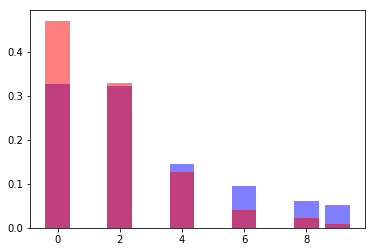

0.0026939774600629332

In [49]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [50]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [51]:
reduce_train.head()

,Clip,Activity,Assessment,Game,acc_Chest Sorter (Assessment),acc_Mushroom Sorter (Assessment),acc_Bird Measurer (Assessment),acc_Cauldron Filler (Assessment),acc_Cart Balancer (Assessment),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,b80e5e84,ecaab346,1340b8d7,160654fd,8b757ab8,1375ccb7,c51d8688,c6971acf,51311d7a,92687c59,a2df0760,74e5f8a7,dcaede90,a592d54e,eb2c19cd,9ee1c98c,895865f3,bfc77bd6,ab4ec3a4,ca11f653,cfbd47c8,5dc079d8,b120f2ac,49ed92e9,8d748b58,89aace00,e57dd7af,17113b36,3bf1cf26,1f19558b,d2278a3b,250513af,3a4be871,5de79a6a,29a42aea,795e4a37,cdd22e43,3edf6747,392e14df,4c2ec19f,3d0b9317,84538528,923afab1,3babcb9b,532a2afb,565a3990,6f4bd64e,ec138c1c,a8876db3,30df3273,7dfe6d8a,f71c4741,884228c8,67439901,cb1178ad,2c4e6db0,df4fe8b6,1b54d27f,363d3849,4ef8cdd3,5290eab1,26fd2d99,9e4c8c7b,7cf1bc53,2b9272f4,c54cf6c5,8d84fa81,bc8f2793,6c930e6e,15eb4a7d,6f4adc4b,461eace6,d3268efa,832735e1,c189aaf2,7372e1a5,9b23e8ee,4e5fc6f5,a0faea5d,90efca10,7d5c30a2,56bcd38d,1575e76c,7525289a,d38c2fd7,022b4259,5a848010,262136f4,0413e89d,b2dba42b,e04fb33d,a52b92d5,5e812b27,6088b756,6043a2b4,b7530680,a76029ee,acf5c23f,45d01abe,63f13dd7,3323d7e9,7ad3efc6,9554a50b,83c6c409,7961e599,e080a381,14de4c5d,f5b8c21a,e4f1efe6,86ba578b,17ca3959,91561152,d51b1749,0a08139c,e37a2b78,28520915,b012cd7f,a5e9da97,5be391b5,3bb91dda,7da34a02,a7640a16,3bb91ced,792530f8,f6947f54,36fa3ebe,e64e2cfd,beb0a7b9,8af75982,bb3e370b,a8a78786,2a444e03,9d29771f,828e68f9,47f43a44,c1cac9a2,5d042115,26a5a3dd,47026d5f,d2e9262e,ea321fb1,69fdac0a,e79f3763,cf7638f3,9e34ea74,d185d3ea,29f54413,c952eb01,58a0de5c,003cd2ee,46b50ba8,88d4a5be,8ac7cce4,6c517a88,e694a35b,598f4598,77261ab5,070a5291,06372577,37c53127,9ce586dd,c2baf0bd,611485c5,37db1c2f,3afb49e6,3d8c61b0,0db6d71d,53c6e11a,30614231,93edfe2e,99abe2bb,d02b7a8e,38074c54,08fd73f3,e7e44842,25fa8af4,3afde5dd,a6d66e51,ecc36b7f,155f62a4,ac92046e,4074bac2,3ddc79c3,6f445b57,76babcde,8d7e386c,9e6b7fb5,2dcad279,499edb7c,6077cc36,ad148f58,5e109ec3,0330ab6a,9c5ef70c,4a09ace1,7fd1ac25,d06f75b5,b88f38da,f806dc10,4901243f,763fc34e,0ce40006,1af8be29,f3cd5473,f7e47413,c74f40cd,0d18d96c,1cc7cfca,00c73085,2b058fe3,55115cbd,907a054b,7f0836bf,77ead60d,5b49460a,d88e8f25,87d743c1,3393b68b,48349b14,4bb2f698,1c178d24,73757a5e,3dcdda7f,28a4eb9a,363c86c9,a29c5338,56817e2b,d45ed6a1,daac11b0,e720d930,d3f1e122,37ee8496,84b0e0c8,dcb55a27,9ed8f6da,9d4e7b25,f32856e4,e5c9df6f,a1e4395d,d9c005dd,cf82af56,27253bdc,ad2fc29c,02a42007,cb6010f8,a1192f43,28ed704e,93b353f2,f50fc6c1,c277e121,c0415e5c,709b1251,86c924c4,5e3ea25a,736f9581,e3ff61fb,5c2f29ca,71fe8f75,bd701df8,b74258a0,a8efe47b,8f094001,33505eae,c7fe2a55,d88ca108,56cd3b43,77c76bc5,15a43e5b,ab3136ba,28f975ea,15f99afc,2230fab4,562cec5f,31973d56,5154fc30,119b5b02,47efca07,9b01374f,4b5efe37,2ec694de,5859dfb6,19967db1,b5053438,85d1b0de,abc5811c,65a38bf7,222660ff,13f56524,b1d5101d,04df9b66,a5be6304,e4d32835,d2659ab4,f56e0afc,3d63345e,1996c610,e5734469,4a4c3d21,16667cc5,90ea0bac,f28c589a,5348fd84,a44b10dc,51102b85,3ee399c3,ecc6157f,c58186bf,5c3d2b2f,bd612267,1cf54632,08ff79ad,3b2048ee,6f8106d9,731c0cbe,2dc29e21,29bdd9ba,71e712d8,0d1da71f,de26c3a6,6d90d394,df4940d3,3ccd3f02,fcfdffb6,37937459,bdf49a58,b7dc8128,1bb5fbdb,fbaf3456,bcceccc6,d122731b,e9c52111,c7128948,ea296733,9b4001e4,6aeafed4,dcb1663e,67aa2ada,857f21c0,d3640339,1325467d,db02c830,7ec0c298,0086365d,f93fc684,3dfd4aa4,cc5087a3,756e5507,05ad839b,5f0eb72c,b2e5b0f1,587b5989,a8cc6fec,a16a373e,99ea62f3,fd20ea40,6bf9e3e1,6cf7d25c,f54238ee,9de5e594,804ee27f,85de926c,5f5b2617,3bfd1a65,4d6737eb,1beb320a,c7f7f0e1,8fee50e2,2a512369,65abac75,e7561dd2,bbfe0445,15ba1109,46cd75b4,7423acbc,01ca3a3c,2fb91ec1,a1bbe385,7ab78247,90d848e0,7d093bf9,4d911100,44cb4907,16dffff1,7040c096,12 Monkeys,Bug Measurer (Activity),Crystal Caves - Level 3,Fireworks (Activity),Ordering Spheres,Honey Cake,Chow Time,Scrub-A-Dub,Welcome to Lost

In [52]:
ajusted_test = reduce_test.copy()

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | subsam... |
-------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.635439	valid_1's rmse: 1.05036
Early stopping, best iteration is:
[8]	training's rmse: 0.939445	valid_1's rmse: 0.992576
Partial score of fold 0 is: 0.5808154080224992
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.635227	valid_1's rmse: 1.08096
Early stopping, best iteration is:
[6]	training's rmse: 0.95294	valid_1's rmse: 1.0064
Partial score of fold 1 is: 0.5659830633963652
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.637378	valid_1's rmse: 1.05933
Early stopping, best iteration is:
[7]	training's rmse: 0.949373	valid_1's rmse: 1.01228
Partial score of fold 2 is: 0.5610738190541913
Training until validation scores don't impr

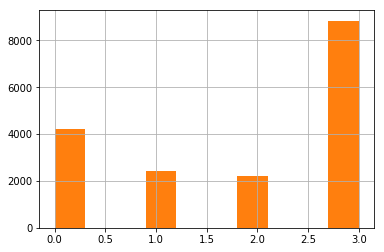

In [53]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    lgb_model= Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals,ps=params)
    print('kappa: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.025, 0.5),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (13, 17),
}

LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
import warnings
init_points = 16
n_iter = 16
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.939224	valid_1's rmse: 0.989315
[200]	training's rmse: 0.883612	valid_1's rmse: 0.978288
[300]	training's rmse: 0.844972	valid_1's rmse: 0.976912
[400]	training's rmse: 0.812401	valid_1's rmse: 0.975941
Early stopping, best iteration is:
[391]	training's rmse: 0.815017	valid_1's rmse: 0.975785
Partial score of fold 0 is: 0.6024634385941072
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.937452	valid_1's rmse: 0.99699
[200]	training's rmse: 0.880922	valid_1's rmse: 0.990009
[300]	training's rmse: 0.842015	valid_1's rmse: 0.989327
[400]	training's rmse: 0.810342	valid_1's rmse: 0.990705
Early stopping, best iteration is:
[334]	training's rmse: 0.830829	valid_1's rmse: 0.988779
Partial score of fold 1 is: 0.5897033294297842
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.940031	valid_1's rmse: 0.99629
[200]	training's rmse: 0.

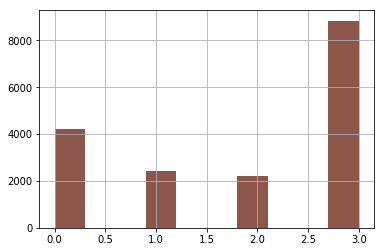

In [54]:
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals, ps=LGB_BO.max['params'])

[0]	train-rmse:1.85639	val-rmse:1.85707
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.01625	val-rmse:1.15205
[200]	train-rmse:0.737264	val-rmse:1.00747
[300]	train-rmse:0.619573	val-rmse:0.984695
[400]	train-rmse:0.560301	val-rmse:0.982245
[500]	train-rmse:0.523623	val-rmse:0.982453
Stopping. Best iteration:
[458]	train-rmse:0.53742	val-rmse:0.982027

Partial score of fold 0 is: 0.5913710592929526
[0]	train-rmse:1.85625	val-rmse:1.8575
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.00922	val-rmse:1.16773
[200]	train-rmse:0.722825	val-rmse:1.02518
[300]	train-rmse:0.603425	val-rmse:0.999148
[400]	train-rmse:0.540252	val-rmse:0.994593
[500]	train-rmse:0.50027	val-rmse:0.994188
[600]	train-rmse:0.474168	val-rmse:0.99495
Stopping. Best iteration:
[502]	train-rmse:0

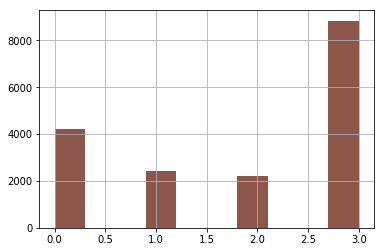

In [55]:
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

(17690, 899)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               180000    
_________________________________________________________________
layer_normalization (LayerNo (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)    

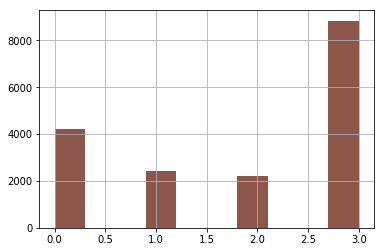

In [56]:
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

# Model Ensemble

In [57]:
lgb_model.y_pred.dtype

dtype('float64')

In [58]:
xgb_model.y_pred.dtype

dtype('float64')

In [59]:
weights = {'lgb': 0.1, 'strong': 0.75, 'xgb': 0.1, 'nn': 0.05}

final_pred = (lgb_model.y_pred * weights['lgb']) + (model1_y_0 * weights['strong'])+ (xgb_model.y_pred * weights['xgb'])+ (nn_model.y_pred * weights['nn'])
#final_pred = cnn_model.y_pred
print(final_pred.shape)

(1000,)


{0: 1.4195132904275958, 1: 1.830515229260598, 2: 2.0476317054112805}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

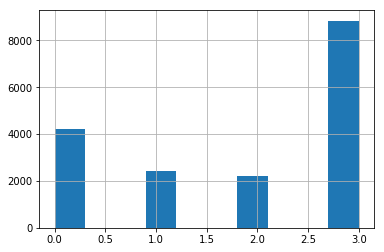

In [60]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)